In [5]:
import cv2
from PIL import Image, ImageTk
from math import sqrt
import math 
import numpy as np

# Use this resizing to use small images 

In [2]:
im = Image.open("logo.jpg")
print(im.size)
resized = im.resize((1100, 1100), Image.ANTIALIAS)
print(resized.size)
#print(list(resized.getdata()))
resized.show()

(360, 360)
(1100, 1100)


In [3]:
im = cv2.imread("logo.jpg")
print(im.shape)
rs = cv2.resize(im, (24,24))
print(rs.shape)
cv2.imshow('original',im)
cv2.waitKey(0)
cv2.imshow('resized',rs)
cv2.waitKey(0)

(360, 360, 3)
(24, 24, 3)


-1

In [4]:

def getHist(imgPix):
    """
    Return bgr Histograms
    """
    imgPix = np.array(imgPix)
    rbgHist= cv2.calcHist(images=[imgPix], 
                        channels=[0, 1, 2], 
                        mask=None, 
                        histSize=[2, 2, 2], 
                        ranges=[0, 256, 0, 256, 0, 256])

    return rbgHist
rs = cv2.resize(im, (24,24))
h = getHist(rs)
v = h.flatten()
print(h)
print(v)
print(np.reshape(v, (2,2,2)))
np.array(list(map(np.float32, v)))


[[[ 12.   0.]
  [  1.  15.]]

 [[ 39.   0.]
  [  6. 503.]]]
[ 12.   0.   1.  15.  39.   0.   6. 503.]
[[[ 12.   0.]
  [  1.  15.]]

 [[ 39.   0.]
  [  6. 503.]]]


array([ 12.,   0.,   1.,  15.,  39.,   0.,   6., 503.], dtype=float32)

# Color Descriptors

In [5]:

def getAvgs(imgPix):
        """
        la moyenne, moment d’ordre un.
        :return: (avgR, avgG, avgB)
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        t = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                t[0] += imgPix[i][j][0]
                t[1] += imgPix[i][j][1]
                t[2] += imgPix[i][j][2]
        t = [y/sz for y in t]
        print('Mean:', imgPix.shape, imgPix.size)
        print(t, "equals")
        
        return list(imgPix.mean(axis=1).mean(axis=0))
    
def getSTDs(imgPix):
        """
        L'écart type, moment d’ordre deux.
        :return:
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        
        mean = getAvgs(imgPix)
        v = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                v[0] += (imgPix[i][j][0] - mean[0])**2
                v[1] += (imgPix[i][j][1] - mean[1])**2
                v[2] += (imgPix[i][j][2] - mean[2])**2
        v = [sqrt(y/sz) for y in v]
        print('STD:')
        print(v, "equals")
        return list(imgPix.std(axis=1).std(axis=0))
    
def getMoments(imgPix):
        """
        moment d’ordre trois.
        :return:
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        
        mean = getAvgs(imgPix)
        v = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                v[0] += (imgPix[i][j][0] - mean[0])**3
                v[1] += (imgPix[i][j][1] - mean[1])**3
                v[2] += (imgPix[i][j][2] - mean[2])**3
        v = [ abs((y/sz))**(1/3) for y in v]
        features = []
        features.extend(mean)
        features.extend(getSTDs(imgPix))
        features.extend(v)
        return features

In [154]:
print(getAvgs(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
[235.69618055555551, 238.1510416666666, 229.22048611111111]


In [155]:
print(getSTDs(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
STD:
[45.77348045746132, 42.14232374114895, 66.36832983674661] equals
[25.119248212652426, 25.890382902339375, 42.49990600721883]


In [156]:
print(getMoments(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
STD:
[45.77348045746132, 42.14232374114895, 66.36832983674661] equals
[235.69618055555551, 238.1510416666666, 229.22048611111111, 25.119248212652426, 25.890382902339375, 42.49990600721883, 61.81698750779069, 56.532930354293505, 90.90555695466534]


# Texture 

In [98]:
import matplotlib.pyplot as plt
def getGaborFilterBank(ksize):
    gaborFilters = []
    _lambda = [0.06, 0.09, 0.13, 0.18, 0.25]
    i = 1
    for lnda in _lambda:
        for tta in np.arange(0, np.pi, np.pi / 8):
            kern = cv2.getGaborKernel((ksize, ksize), 3.0, tta, lnda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            #cv2.imshow('{}'.format(i), kern)
            #cv2.waitKey(0)
            i += 1
            gaborFilters.append(kern)
    return gaborFilters

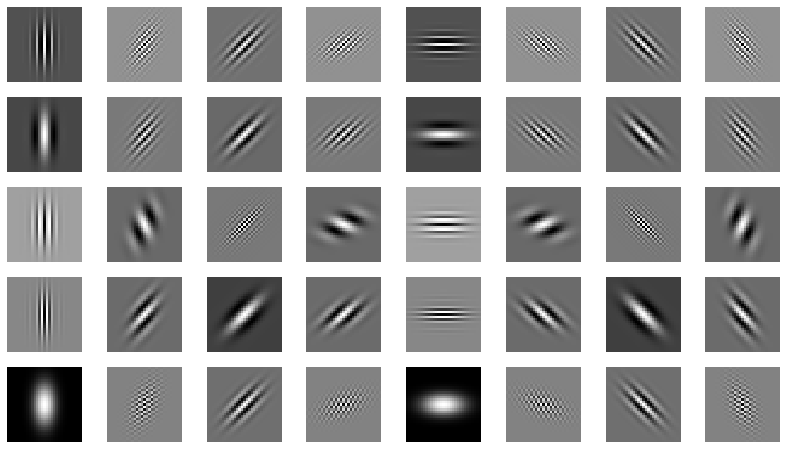

In [99]:
t = getGaborFilterBank(31)

fig=plt.figure(figsize=(14, 8))
columns = 8
rows = 5
for i in range(1, columns*rows +1):
    img = t[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [100]:
def getGaborFeatures(image_file):
        bank = getGaborFilterBank(31)
        image         = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        #cv2.imshow('{}'.format(i), kernel)
        #cv2.waitKey(0)
        filteredImgs  = []
        features = []
        for kernel in bank:
            filtred = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            filteredImgs.append(filtred)
            features.append(kernel.mean())
            features.append( kernel.std())
            
        #cv2.imwrite("{}.jpg".format(1), filtered_img)
        # convert matrix to vector 
        #descriptor = cv2.resize(filtered_img, (3*width, 3*heigth), interpolation=cv2.INTER_CUBIC)
        
        return filteredImgs, features

[[162 163 163 ... 150 154 172]
 [163 162 164 ... 152 156 171]
 [163 163 163 ... 151 155 170]
 ...
 [162 163 164 ... 152 155 167]
 [163 162 164 ... 156 156 166]
 [163 163 163 ... 154 157 168]]


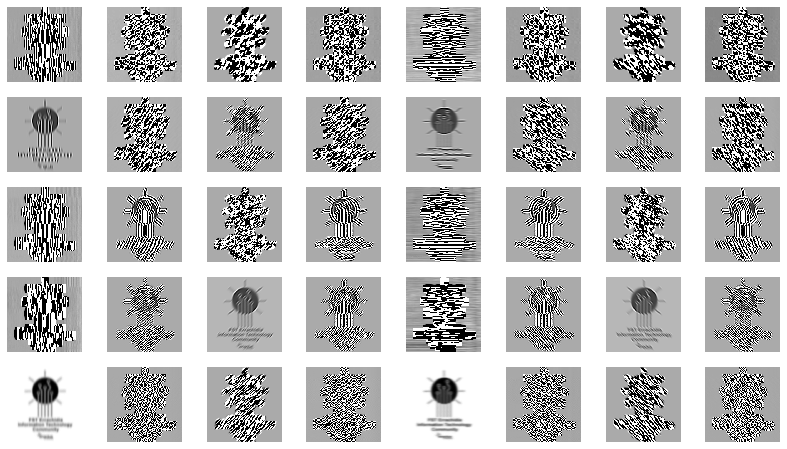

80


In [105]:
t, f = getGaborFeatures("logo.jpg")

fig=plt.figure(figsize=(14, 8))
columns = 8
rows = 5
print(t[0])
for i in range(1, columns*rows +1):
    img = t[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()
print(len(f))

In [44]:
for i in range(1,9):
    cv2.imshow('{}'.format(i), getGabor("gb.png", i))
    cv2.waitKey(0)

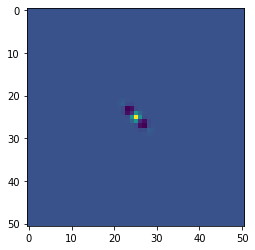

In [61]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=QEz4bG9P3Qs


"""
@author: Sreenivas Bhattiprolu
What are features? 
"""

##############################################
#Gabor filter, multiple filters in one. Generate fiter bank. 
"""
For image processing and computer vision, Gabor filters are generally 
used in texture analysis, edge detection, feature extraction, etc. 
Gabor filters are special classes of bandpass filters, i.e., they allow a certain 
‘band’ of frequencies and reject the others.
ksize Size of the filter returned.
sigma Standard deviation of the gaussian envelope.
theta Orientation of the normal to the parallel stripes of a Gabor function.
lambda Wavelength of the sinusoidal factor.
gamma Spatial aspect ratio.
psi Phase offset.
ktype Type of filter coefficients. It can be CV_32F or CV_64F.
indicates the type and range of values that each pixel in the Gabor kernel can hold.
Basically float32 or float64
"""
 
import numpy as np
import cv2
import matplotlib.pyplot as plt

ksize = 51 #Use size that makes sense to the image and fetaure size. Large may not be good. 
#On the synthetic image it is clear how ksize affects imgae (try 5 and 50)
sigma = 2 #Large sigma on small features will fully miss the features. 
theta = 1*np.pi/4  #/4 shows horizontal 3/4 shows other horizontal. Try other contributions
lamda =  5 #1*np.pi /8  #1/4 works best for angled. 
gamma=3  #Value of 1 defines spherical. Calue close to 0 has high aspect ratio
#Value of 1, spherical may not be ideal as it picks up features from other regions.
phi = 0  #Phase offset. I leave it to 0. 


kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)


img = cv2.imread('logo.jpg')
#img = cv2.imread('BSE_Image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

kernel_resized = cv2.resize(kernel, (400, 400))                    # Resize image
cv2.imshow('Kernel', kernel_resized)
cv2.imshow('Original Img.', img)
cv2.imshow('Filtered', fimg)
cv2.waitKey()
cv2.destroyAllWindows()


In [50]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=BTbIS1mriuY



import numpy as np
import cv2
import pandas as pd
 
#img = cv2.imread('BSE_Image.jpg')
img = cv2.imread('wood.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
#Here, if you have multichannel image then extract the right channel instead of converting the image to grey. 
#For example, if DAPI contains nuclei information, extract the DAPI channel image first. 

#Multiple images can be used for training. For that, you need to concatenate the data

#Save original image pixels into a data frame. This is our Feature #1.
img2 = img.reshape(-1)
df = pd.DataFrame()
df['Original Image'] = img2

#Generate Gabor features
num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
kernels = []  #Create empty list to hold all kernels that we will generate in a loop
for theta in range(2):   #Define number of thetas. Here only 2 theta values 0 and 1/4 . pi 
    theta = theta / 4. * np.pi
    for sigma in (1, 3):  #Sigma with values of 1 and 3
        for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
            for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                           
                gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
#                print(gabor_label)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)
                #Now filter the image and add values to a new column 
                fimg = cv2.filter2D(img2, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1  #Increment for gabor column label
                
print(df.head())

df.to_csv("Gabor.csv")

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.05
Gabor2 : theta= 0.0 : sigma= 1 : lamda= 0.0 : gamma= 0.5
Gabor3 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor4 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor5 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor6 : theta= 0.0 : sigma= 1 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor7 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.05
Gabor8 : theta= 0.0 : sigma= 1 : lamda= 2.356194490192345 : gamma= 0.5
Gabor9 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.05
Gabor10 : theta= 0.0 : sigma= 3 : lamda= 0.0 : gamma= 0.5
Gabor11 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.05
Gabor12 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor13 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.05
Gabor14 : theta= 0.0 : sigma= 3 : lamda= 1.5707963267948966 : gamma= 0.5
Gabor15 : theta= 0.0 : sigma= 3 : lamda= 2

In [3]:
help(cv2.getGaborKernel)

Help on built-in function getGaborKernel:

getGaborKernel(...)
    getGaborKernel(ksize, sigma, theta, lambd, gamma[, psi[, ktype]]) -> retval
    .   @brief Returns Gabor filter coefficients.
    .   
    .   For more details about gabor filter equations and parameters, see: [Gabor
    .   Filter](http://en.wikipedia.org/wiki/Gabor_filter).
    .   
    .   @param ksize Size of the filter returned.
    .   @param sigma Standard deviation of the gaussian envelope.
    .   @param theta Orientation of the normal to the parallel stripes of a Gabor function.
    .   @param lambd Wavelength of the sinusoidal factor.
    .   @param gamma Spatial aspect ratio.
    .   @param psi Phase offset.
    .   @param ktype Type of filter coefficients. It can be CV_32F or CV_64F .



In [22]:
17*17*17

4913

In [23]:
26*26

676

In [ ]:
#signature = open(index, 'r')
            '''for line in signature:
                line = line.replace("[", "").replace("]", "").replace("(", "").replace(")", "").split(",")
                filename = line[0]
                avgs = [float(x) for x in line[1:]]
                # TODO: Add to M tree
                self.addObjectsToTree([filename, avgs])
                print(".", end= " ")'''

# Save to desk
            '''
            indexes = open('indexBase.txt', 'w')
            for i in range(len(self.indexBase)):
                indexes.write(str(self.indexBase[i]))
                indexes.write("\n")
            indexes.close()
            '''